### Colab 에서 처음 실행시 아래 모듈 설치 필요함

In [1]:
# !pip install pytorch-forecasting pytorch-lightning -q

In [2]:
# from pytorch_forecasting.models import TemporalFusionTransformer

# print("TemporalFusionTransformer 로드 성공!")

In [3]:
# import pytorch_forecasting
# print("pytorch_forecasting 버전:", pytorch_forecasting.__version__)

### 필요 모듈 import

In [4]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from collections import defaultdict

from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics.base_metrics import Metric as PFMetric
from pytorch_forecasting.metrics import CrossEntropy

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

# 경고 무시 설정
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="pytorch_forecasting")

### cuda 사용 확인

In [5]:
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('GPU available')
else:
    device = 'cpu'
    print('GPU not available')

GPU available


### colab file path (각 환경에 맞게 변경 후 사용)

In [6]:
fixed_file_path = "/content/drive/MyDrive/AIFFELTHON_HARA/dataset/train/merged_pedestrian_behavior.csv"

### 새로운 데이터셋으로 merged_pedestrian_behavior.csv 을 생성할 경우 아래 셀들의 주석을 풀어서 실행

In [7]:
# # 보행자 CSV 파일이 저장된 폴더 경로
# data_folder = "/content/drive/MyDrive/AIFFELTHON_HARA/dataset/train"

# # 모든 CSV 파일 찾기
# csv_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

# # 숫자 기준으로 파일 정렬 (Video_1_dataset.csv → Video_2_dataset.csv → ...)
# csv_files_sorted = sorted(csv_files, key=lambda x: int(re.search(r"Video_(\d+)_dataset\.csv", x).group(1)) if re.search(r"Video_(\d+)_dataset\.csv", x) else float('inf'))

# # 모든 CSV 파일 로드 및 frame 컬럼 추가
# all_dataframes = []

# print("CSV 파일 로드 시작...")

# for filename in csv_files_sorted:
#     file_path = os.path.join(data_folder, filename)

#     # 파일 로드 로그 출력
#     print(f"처리 중: {filename}")

#     # 파일 이름에서 pedestrian_id 추출 (예: Video_1_dataset.csv → pedestrian_id = 1)
#     match = re.search(r"Video_(\d+)_dataset\.csv", filename)
#     if match:
#         pedestrian_id = int(match.group(1))  # "Video_1_dataset.csv" → 1

#         # CSV 파일 로드
#         df = pd.read_csv(file_path, header=None)  # 컬럼명이 없을 수도 있으므로 header=None 사용

#         # 입력 데이터 (69개)와 행동 라벨 (마지막 열) 분리
#         num_features = 69  # Keypoints(22개) + CoM(3D) = 69차원 입력
#         df_features = df.iloc[:, :num_features]  # 69개 입력 피처
#         df_labels = df.iloc[:, num_features]  # 마지막 열이 행동 클래스 라벨 (0~3)

#         # 컬럼 이름 설정
#         keypoint_columns = [f"kp_{i}" for i in range(num_features)]  # "kp_0", "kp_1", ..., "kp_68"
#         df_features.columns = keypoint_columns  # 입력 피처 이름 지정
#         df_labels.name = "behavior_label"  # 행동 클래스 열 이름 지정

#         # 보행자 ID 추가
#         df_features["pedestrian_id"] = pedestrian_id

#         # 행동 라벨 추가 - 명시적으로 정수형(int)으로 변환
#         df_features["behavior_label"] = df_labels

#         # frame 컬럼 추가 (0부터 시작하는 인덱스)
#         df_features.insert(0, "frame", range(len(df_features)))

#         # 리스트에 저장
#         all_dataframes.append(df_features)

#         # 파일 처리 완료 로그 출력
#         print(f"처리 완료: {filename} (Samples: {len(df_features)})")

# # 모든 데이터를 하나의 DataFrame으로 합침
# full_df = pd.concat(all_dataframes, ignore_index=True)

# # 데이터 타입 확인
# print("\n데이터 타입 확인:")
# for col in ["frame", "pedestrian_id", "behavior_label"]:
#     print(f"{col}: {full_df[col].dtype}")

# # 행동 라벨 분포 확인
# print("\n행동 라벨 분포:")
# print(full_df["behavior_label"].value_counts())

In [8]:
# # 숫자형 데이터만 선택하여 NaN 및 inf 값 확인
# numeric_df = full_df.select_dtypes(include=[np.number])  # 숫자형(float, int) 데이터만 선택

# # NaN(결측값) 개수 확인
# missing_values = numeric_df.isna().sum()
# print("NaN (결측값) 개수:\n", missing_values[missing_values > 0])

# # Inf(무한대) 값 확인
# infinite_values = np.isinf(numeric_df).sum()
# print("\nInf (무한대) 개수:\n", infinite_values[infinite_values > 0])

In [9]:
# # 결측치 제거
# full_df.dropna(inplace=True)
# print("결측값 제거\n")

# # 숫자형 데이터만 선택하여 NaN 및 inf 값 확인
# numeric_df = full_df.select_dtypes(include=[np.number])  # 숫자형(float, int) 데이터만 선택

# # NaN(결측값) 개수 확인
# missing_values = numeric_df.isna().sum()
# print("NaN (결측값) 개수:\n", missing_values[missing_values > 0])

# # Inf(무한대) 값 확인
# infinite_values = np.isinf(numeric_df).sum()
# print("\nInf (무한대) 개수:\n", infinite_values[infinite_values > 0])

In [10]:
# # 정수로 변환
# full_df["behavior_label"] = full_df["behavior_label"].astype(int)

# # 최종 데이터 저장
# full_df.to_csv(fixed_file_path, index=False)

# print("모든 CSV 파일 처리 완료!")
# print(f"최종 데이터 저장: {fixed_file_path}")

### 병합된 csv 파일 load

In [11]:
# 병합된 CSV 데이터 로드
df = pd.read_csv(fixed_file_path)

# 데이터프레임의 컬럼 확인
print("Columns in CSV file:", df.columns)

# 각 컬럼의 데이터 타입 출력
print("데이터 타입 확인:")
print(df.dtypes)

Columns in CSV file: Index(['frame', 'kp_0', 'kp_1', 'kp_2', 'kp_3', 'kp_4', 'kp_5', 'kp_6', 'kp_7',
       'kp_8', 'kp_9', 'kp_10', 'kp_11', 'kp_12', 'kp_13', 'kp_14', 'kp_15',
       'kp_16', 'kp_17', 'kp_18', 'kp_19', 'kp_20', 'kp_21', 'kp_22', 'kp_23',
       'kp_24', 'kp_25', 'kp_26', 'kp_27', 'kp_28', 'kp_29', 'kp_30', 'kp_31',
       'kp_32', 'kp_33', 'kp_34', 'kp_35', 'kp_36', 'kp_37', 'kp_38', 'kp_39',
       'kp_40', 'kp_41', 'kp_42', 'kp_43', 'kp_44', 'kp_45', 'kp_46', 'kp_47',
       'kp_48', 'kp_49', 'kp_50', 'kp_51', 'kp_52', 'kp_53', 'kp_54', 'kp_55',
       'kp_56', 'kp_57', 'kp_58', 'kp_59', 'kp_60', 'kp_61', 'kp_62', 'kp_63',
       'kp_64', 'kp_65', 'kp_66', 'kp_67', 'kp_68', 'pedestrian_id',
       'behavior_label'],
      dtype='object')
데이터 타입 확인:
frame               int64
kp_0              float64
kp_1              float64
kp_2              float64
kp_3              float64
                   ...   
kp_66             float64
kp_67             float64
kp_68       

### 데이터 분포 시각화

<ipython-input-12-564e3f7514d3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["behavior_label"], palette="viridis")


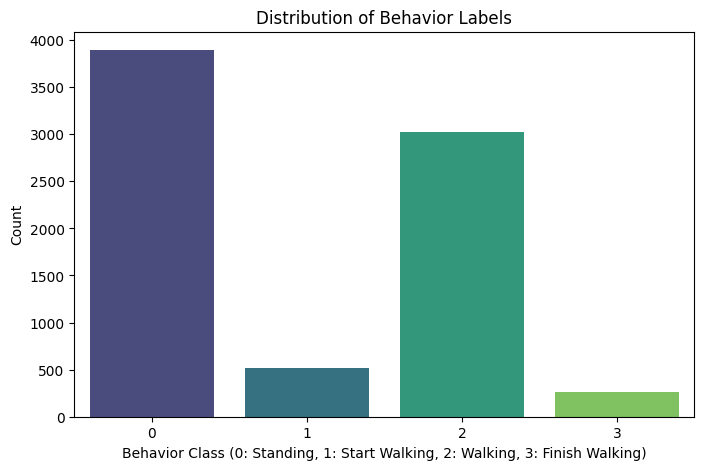

In [12]:
# 행동 클래스(Behavior Label) 분포 시각화
plt.figure(figsize=(8, 5))
sns.countplot(x=df["behavior_label"], palette="viridis")
plt.xlabel("Behavior Class (0: Standing, 1: Start Walking, 2: Walking, 3: Finish Walking)")
plt.ylabel("Count")
plt.title("Distribution of Behavior Labels")
plt.show()

<ipython-input-13-9bc207f1e393>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["pedestrian_id"], palette="coolwarm")


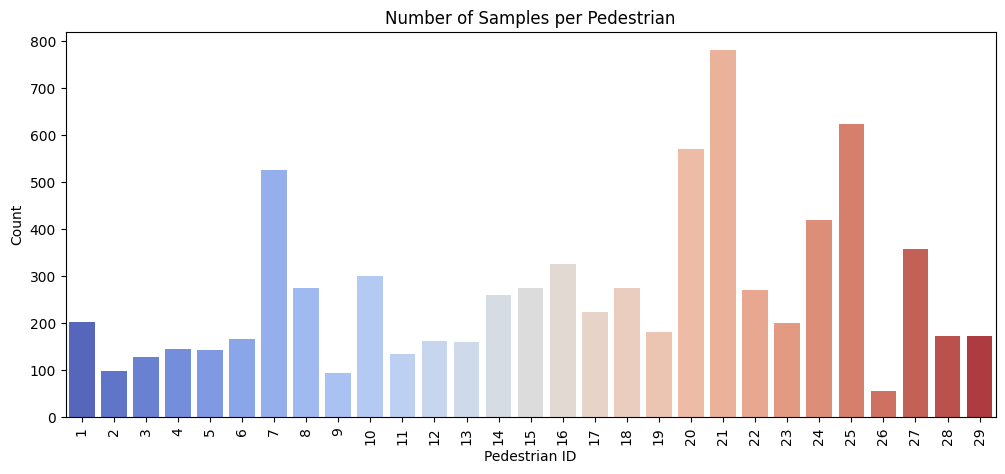

In [13]:
# 보행자 ID별 샘플 개수 시각화
plt.figure(figsize=(12, 5))
sns.countplot(x=df["pedestrian_id"], palette="coolwarm")
plt.xlabel("Pedestrian ID")
plt.ylabel("Count")
plt.title("Number of Samples per Pedestrian")
plt.xticks(rotation=90)  # X축 글자가 겹치지 않도록 회전
plt.show()

<Figure size 1500x800 with 0 Axes>

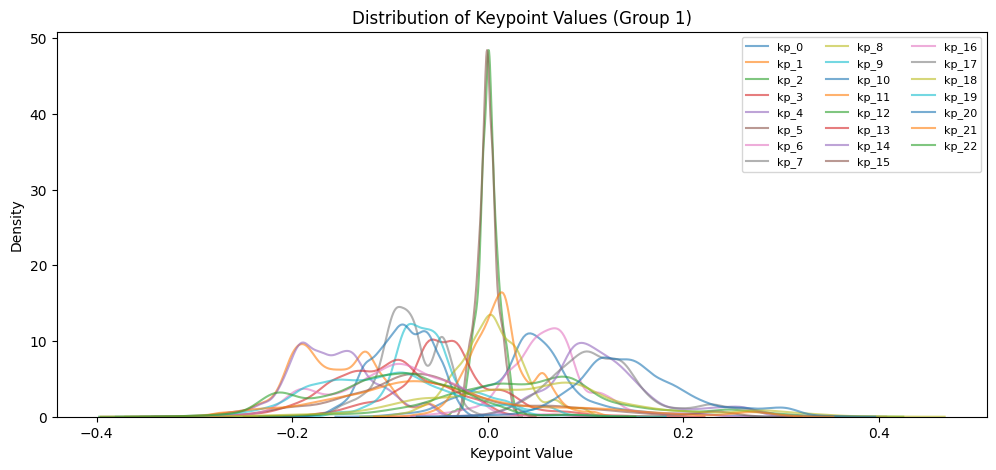

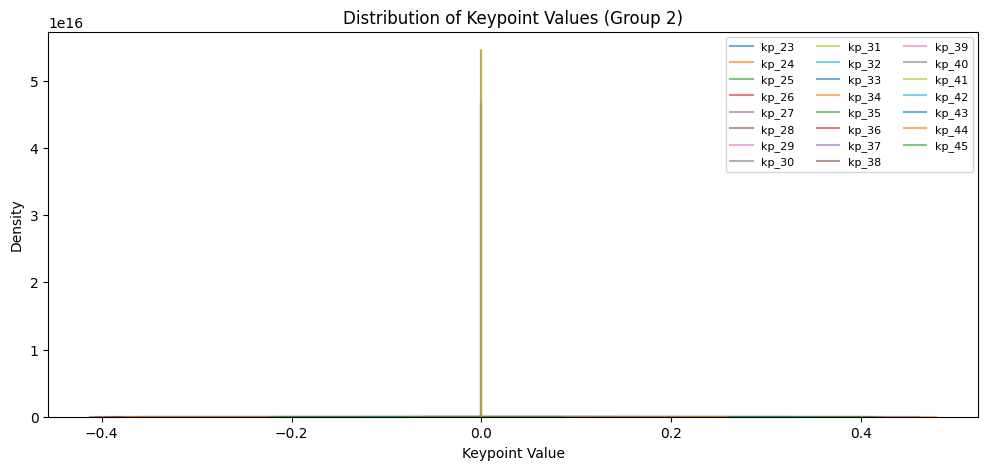

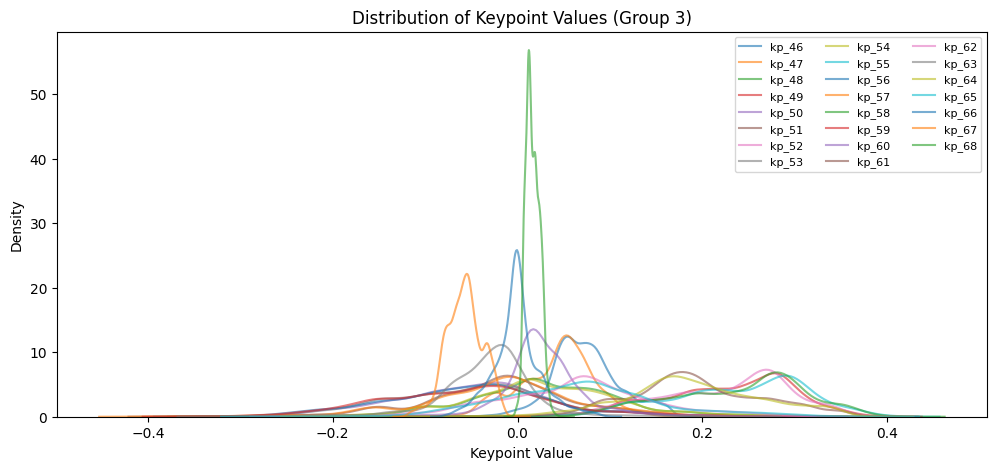

In [14]:
# Keypoint 컬럼 리스트 (kp_0 ~ kp_68)
keypoint_columns = [f"kp_{i}" for i in range(69)]

# Keypoints를 3개의 그룹으로 나누기 (예: 23개씩 3개)
num_splits = 3
split_size = len(keypoint_columns) // num_splits

# 그룹별 KDE Plot 시각화
plt.figure(figsize=(15, 8))
for i in range(num_splits):
    subset = keypoint_columns[i * split_size:(i + 1) * split_size]

    plt.figure(figsize=(12, 5))
    for col in subset:
        sns.kdeplot(df[col], label=col, alpha=0.6)
    plt.xlabel("Keypoint Value")
    plt.ylabel("Density")
    plt.title(f"Distribution of Keypoint Values (Group {i+1})")
    plt.legend(ncol=3, fontsize=8)
    plt.show()

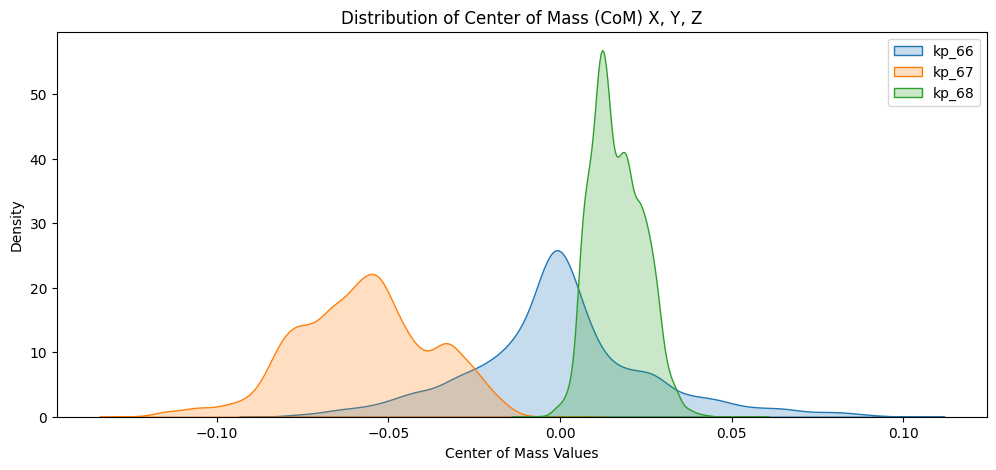

In [15]:
# KDE Plot 실행
plt.figure(figsize=(12, 5))
for col in ["kp_66", "kp_67", "kp_68"]:
    sns.kdeplot(df[col], label=col, fill=True)
plt.xlabel("Center of Mass Values")
plt.ylabel("Density")
plt.title("Distribution of Center of Mass (CoM) X, Y, Z")
plt.legend()
plt.show()

### Train, validation 데이터셋

In [16]:
# Random Seed 고정 (재현성 확보)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

# pedestrian_id를 문자열로 변환 후 카테고리 타입으로 변환
df["pedestrian_id"] = df["pedestrian_id"].astype(str).astype('category')

# 그룹 정보 생성 - 카테고리 타입을 문자열로 변환 후 연결
df["group"] = df["pedestrian_id"].astype(str) + "_" + df["frame"].astype(str)

# 그룹별 행동 라벨 확인 (각 그룹의 첫 번째 행동 라벨 사용)
group_labels = df.groupby("group")["behavior_label"].first().reset_index()

# 그룹을 클래스 비율을 유지하면서 분할
train_groups, val_groups = train_test_split(
    group_labels["group"],
    test_size=0.2,
    stratify=group_labels["behavior_label"],
    random_state=42
)

# 분할된 그룹 목록을 사용하여 훈련 및 검증 데이터프레임 생성
train_df = df[df["group"].isin(train_groups)].copy()
val_df = df[df["group"].isin(val_groups)].copy()

# 불필요한 'group' 열 제거
train_df = train_df.drop(columns=["group"])
val_df = val_df.drop(columns=["group"])

print(f"훈련 데이터 크기: {len(train_df)}")
print(f"검증 데이터 크기: {len(val_df)}")

# 클래스 분포 확인
print("\n훈련 데이터의 클래스 분포:")
print(train_df["behavior_label"].value_counts(normalize=True))

print("\n검증 데이터의 클래스 분포:")
print(val_df["behavior_label"].value_counts(normalize=True))

# 시계열 데이터셋 설정
max_encoder_length = 10  # 과거 10 프레임 사용
max_prediction_length = 1  # 현재 행동 예측 (1개 클래스 출력)

# 입력 데이터 69개 (Keypoints + CoM)
feature_columns = [f"kp_{i}" for i in range(69)]  # Keypoints + CoM (69차원)

# NaNLabelEncoder 생성 및 전체 데이터로 학습 (훈련/검증 둘 다 동일한 인코더 사용)
pedestrian_encoder = NaNLabelEncoder().fit(df["pedestrian_id"])

# 훈련 데이터셋 생성
train_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="frame",  # 프레임 번호
    target="behavior_label",  # 예측할 행동 클래스 (4개)
    group_ids=["pedestrian_id"],  # 보행자별 데이터 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["pedestrian_id"],  # 보행자 ID를 Static Variable로 설정
    time_varying_known_reals=["frame"],  # 시간에 따라 변하는 변수
    time_varying_unknown_reals=feature_columns,  # 69차원 입력 데이터
    categorical_encoders={"pedestrian_id": pedestrian_encoder},  # 인코더 명시적 지정
    target_normalizer=None,  # 분류 문제이므로 normalizer 불필요
    allow_missing_timesteps=True,  # 중간 프레임 누락 허용
)

# 검증 데이터셋 생성 (훈련 데이터셋의 설정을 재사용)
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    val_df,  # 검증용 데이터
    stop_randomization=True  # 검증 시 랜덤화 비활성화
)

print("TimeSeriesDataSet 생성 완료!")


훈련 데이터 크기: 6151
검증 데이터 크기: 1538

훈련 데이터의 클래스 분포:
behavior_label
0    0.506422
2    0.392944
1    0.066981
3    0.033653
Name: proportion, dtype: float64

검증 데이터의 클래스 분포:
behavior_label
0    0.506502
2    0.392718
1    0.066970
3    0.033810
Name: proportion, dtype: float64
TimeSeriesDataSet 생성 완료!


In [17]:
# batch_size
batch_size = 16 # 32

# 훈련 데이터로더
train_dataloader = train_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

# 검증 데이터로더
val_dataloader = val_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

print(f"데이터로더 생성 완료 (Train 배치: {len(train_dataloader)}, Val 배치: {len(val_dataloader)})")

데이터로더 생성 완료 (Train 배치: 296, Val 배치: 19)


In [18]:
# 타겟 변수 범위 확인
print("behavior_label 고유 값:", np.unique(train_df["behavior_label"]))
print("behavior_label 최소값:", train_df["behavior_label"].min())
print("behavior_label 최대값:", train_df["behavior_label"].max())

# 데이터 로더 첫 번째 배치 확인
print("\n데이터 로더 확인:")
for batch_idx, batch in enumerate(train_dataloader):
    x, y = batch

    if isinstance(y, (list, tuple)) and len(y) > 0:
        y_sample = y[0]
        print(f"타겟 형상: {y_sample.shape}")
        print(f"타겟 데이터 타입: {y_sample.dtype}")
        print(f"타겟 고유 값: {torch.unique(y_sample)}")
        print(f"타겟 최소값: {y_sample.min()}")
        print(f"타겟 최대값: {y_sample.max()}")
    else:
        print(f"타겟 형상: {y.shape}")
        print(f"타겟 데이터 타입: {y.dtype}")
        print(f"타겟 고유 값: {torch.unique(y)}")
        print(f"타겟 최소값: {y.min()}")
        print(f"타겟 최대값: {y.max()}")

    break  # 첫 번째 배치만 확인

behavior_label 고유 값: [0 1 2 3]
behavior_label 최소값: 0
behavior_label 최대값: 3

데이터 로더 확인:
타겟 형상: torch.Size([16, 1])
타겟 데이터 타입: torch.int64
타겟 고유 값: tensor([0, 2, 3])
타겟 최소값: 0
타겟 최대값: 3


### FocalLoss 구현

In [19]:
class FocalLoss(PFMetric):
    """
    Focal Loss for multi-class classification in time series forecasting.
    Compatible with pytorch_forecasting metric system.

    Args:
        gamma: focusing parameter - higher values focus more on hard examples (default: 2.0)
        alpha: optional weighting factor for class imbalance (default: None)
        reduction: reduction to apply to the output ("none"|"mean"|"sum") (default: "mean")
        ignore_index: target value to ignore (default: -100)
        prediction_length: prediction length (default: 1)
    """
    def __init__(
        self,
        gamma: float = 2.0,
        alpha: torch.Tensor = None,
        reduction: str = "mean",
        ignore_index: int = -100,
        prediction_length: int = 1,
        **kwargs
    ):
        super().__init__(reduction=reduction, **kwargs)
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.prediction_length = prediction_length

        # 클래스 불균형 처리를 위한 알파 설정
        if alpha is not None:
            self.register_buffer("alpha", alpha)
        else:
            self.alpha = None

    def loss(self, y_pred, y_actual):
        """
        Calculate focal loss with proper scaling.

        Args:
            y_pred: network prediction tensor of shape [batch_size, ..., n_classes]
            y_actual: actual values of shape [batch_size, ...] or tuple of tensors

        Returns:
            torch.Tensor: loss
        """
        # 타겟 처리 - 튜플인 경우 첫 번째 요소 사용
        if isinstance(y_actual, tuple):
            y_actual = y_actual[0]  # 첫 번째 요소 사용

        # 타겟 차원 조정
        if y_actual.dim() > 1 and y_actual.size(-1) == 1:
            y_actual = y_actual.squeeze(-1)

        # 예측 텐서 형태 조정
        if y_pred.ndim > 2:
            y_pred = y_pred.reshape(-1, y_pred.size(-1))

        # 타겟 텐서도 동일하게 조정
        y_actual = y_actual.reshape(-1)

        # 유효한 인덱스 마스크
        valid_mask = y_actual != self.ignore_index
        y_actual = y_actual[valid_mask].long()
        y_pred = y_pred[valid_mask]

        if y_actual.numel() == 0:
            return torch.tensor(0.0, device=y_pred.device)

        # 로그 소프트맥스 계산
        log_softmax = F.log_softmax(y_pred, dim=-1)

        # 원-핫 인코딩 대신 gather 사용
        log_pt = log_softmax.gather(1, y_actual.unsqueeze(1)).squeeze(1)
        pt = torch.exp(log_pt)

        # 기본 교차 엔트로피 계산 (-log(pt))
        ce_loss = -log_pt

        # 포컬 가중치 계산: (1-pt)^gamma
        focal_weight = (1 - pt) ** self.gamma

        # 클래스 가중치 적용 (알파가 있는 경우)
        if self.alpha is not None:
            alpha_weight = self.alpha.gather(0, y_actual)
            focal_weight = focal_weight * alpha_weight

        # 최종 손실 계산
        loss = focal_weight * ce_loss

        # 손실 스케일링 - 일반적인 손실 범위로 조정
        # 손실 값이 너무 작은 경우 10을 곱해 범위 조정
        if loss.mean() < 0.01:
            loss = loss * 10.0

        # 손실 축소
        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:  # none
            return loss

    def to_prediction(self, y_actual):
        """
        Convert target tensor to the right format.

        Args:
            y_actual: actual values (tensor or tuple)

        Returns:
            torch.Tensor: transformed tensor
        """
        # 튜플인 경우 첫 번째 요소 사용
        if isinstance(y_actual, tuple):
            y_actual = y_actual[0]

        # 다차원 텐서 처리
        if y_actual.ndim > 2:
            y_actual = y_actual.reshape(-1, y_actual.size(-1))

        # 마지막 차원이 1인 경우 제거
        if y_actual.size(-1) == 1:
            y_actual = y_actual.squeeze(-1)

        return y_actual

    def to_quantiles(self, y_pred):
        """
        Convert network prediction to quantiles.
        Not relevant for classification but required by the interface.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: prediction
        """
        return y_pred

    def update(self, y_pred, y_actual):
        """
        Update metric state with predictions and targets.
        Required by the interface.

        Args:
            y_pred: predictions from model
            y_actual: actual values
        """
        # 손실 계산
        loss = self.loss(y_pred, y_actual)
        self.val = loss  # 현재 손실 값 저장

    def compute(self):
        """
        Compute the metric.
        Required by the interface.

        Returns:
            torch.Tensor: metric value
        """
        return self.val

### 커스텀 콜백 정의

In [20]:
# 학습 및 검증 중 손실과 정확도를 기록할 리스트 초기화
train_losses = []
val_losses = []
train_accs = []
val_accs = []

# 커스텀 콜백 정의
class AccuracyCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_accs = []
        self.val_accs = []
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # 훈련 손실 기록
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

        # 훈련 정확도 계산 및 기록
        train_acc = self._calculate_accuracy(pl_module, train_dataloader, max_batches=5)
        self.train_accs.append(train_acc)
        print(f"Epoch {trainer.current_epoch}: Train Acc = {train_acc:.4f}")

    def on_validation_epoch_end(self, trainer, pl_module):
        # 검증 손실 기록
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

        # 검증 정확도 계산 및 기록
        val_acc = self._calculate_accuracy(pl_module, val_dataloader)
        self.val_accs.append(val_acc)
        print(f"Epoch {trainer.current_epoch}: Valid Acc = {val_acc:.4f}")

    def _calculate_accuracy(self, model, dataloader, max_batches=None):
        """정확도 계산 메서드"""
        model.eval()
        correct = 0
        total = 0
        device = next(model.parameters()).device

        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                # 배치 제한 (선택적)
                if max_batches is not None and batch_idx >= max_batches:
                    break

                x, y = batch

                # 데이터를 모델과 동일한 장치로 이동
                if isinstance(x, dict):
                    for k in x:
                        if isinstance(x[k], torch.Tensor):
                            x[k] = x[k].to(device)
                else:
                    x = x.to(device)

                # 타겟 처리
                if isinstance(y, (list, tuple)) and len(y) > 0:
                    y = y[0].to(device)
                elif isinstance(y, torch.Tensor):
                    y = y.to(device)

                # 예측
                outputs = model(x)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # 클래스 예측
                _, predicted = torch.max(outputs, dim=-1)

                # 타겟 형태 조정
                if y.dim() > 1:
                    if y.dim() == 2 and y.size(1) == 1:
                        y = y.squeeze(1)
                    elif y.dim() == 3:
                        if y.size(1) == 1 and y.size(2) == 1:
                            y = y.squeeze()
                        else:
                            y = y[:, 0, 0]

                # 정확도 계산
                correct += (predicted == y).sum().item()
                total += y.size(0)

        model.train()
        # 정확도를 0~1 사이 값으로 반환
        acc = correct / total if total > 0 else 0
        return acc

    def plot_metrics(self, save_path=None):
        """메트릭 그래프 그리기"""
        # 값 확인 및 정규화 (데이터가 비정상적인 경우를 처리)
        norm_train_accs = []
        norm_val_accs = []

        for acc in self.train_accs:
            # 만약 정확도가 0~1 범위가 아니라면 정규화
            if acc > 1.0:
                norm_train_accs.append(acc / 100.0 if acc > 100 else acc / 10.0)
            else:
                norm_train_accs.append(acc)

        for acc in self.val_accs:
            # 만약 정확도가 0~1 범위가 아니라면 정규화
            if acc > 1.0:
                norm_val_accs.append(acc / 100.0 if acc > 100 else acc / 10.0)
            else:
                norm_val_accs.append(acc)

        plt.figure(figsize=(16, 6))

        # 손실 그래프
        plt.subplot(1, 2, 1)
        if len(self.train_losses) > 0:
            plt.plot(self.train_losses, 'r-o', label='Train Loss')
        if len(self.val_losses) > 0:
            plt.plot(self.val_losses, 'b-s', label='Valid Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        # 정확도 그래프
        plt.subplot(1, 2, 2)
        if len(norm_train_accs) > 0:
            plt.plot(norm_train_accs, 'r-', label='Train Acc.')
        if len(norm_val_accs) > 0:
            plt.plot(norm_val_accs, 'b-x', label='Valid Acc.')
        plt.title('Accuracy History')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        plt.ylim(0.0, 1.0)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

        # 정확도 값 출력
        print("원본 훈련 정확도:", self.train_accs)
        print("원본 검증 정확도:", self.val_accs)
        print("정규화된 훈련 정확도:", norm_train_accs)
        print("정규화된 검증 정확도:", norm_val_accs)

### Custom TFT 모델 구현

In [22]:
# 커스텀 TFT 클래스 정의 (시각화 오류 우회)
class CustomTFT(TemporalFusionTransformer):
    def log_prediction(self, x, out, batch_idx, **kwargs):
        # 시각화 없이 빈 로그 반환
        return {}

In [23]:
# 모델 저장 경로 설정
checkpoint_dir = '/content/drive/MyDrive/AIFFELTHON_HARA/Model/TFT'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [24]:
# CUDA 환경 설정
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# 4개 클래스에 대한 가중치 설정 (클래스 불균형 처리)
# 소수 클래스에 더 높은 가중치 부여
alpha = torch.tensor([0.25, 2.0, 0.5, 2.0], device=device)  # Standing, Start Walking, Walking, Finish Walking

# FocalLoss 인스턴스 생성
focal_loss = FocalLoss(gamma=2.0, alpha=alpha)

tft = CustomTFT.from_dataset(
    train_dataset,
    hidden_size=32,
    lstm_layers=2,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=4,
    loss=focal_loss,
    learning_rate=0.001,
    log_interval=50, # 1000,  # 시각화 빈도 줄이기
    reduce_on_plateau_patience=5
)

print(f"모델 파라미터 수: {tft.size()/1e3:.1f}k")

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


모델 파라미터 수: 243.2k


### 학습 루프 및 시각화 코드

In [25]:
# 2. 콜백 설정
# 조기 종료 콜백
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=8,
    verbose=True,
    mode="min"
)

# 학습률 모니터링 콜백
lr_logger = LearningRateMonitor()

# 모델 체크포인트 콜백
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="tft-pedestrian-{epoch:02d}",
    monitor="val_loss",
    save_top_k=1,
    mode="min"
)

In [26]:
# # 3. 트레이너 설정
# # 메트릭 콜백 인스턴스 생성
# metrics_callback = MetricsCallback()

# # 트레이너 설정에 메트릭 콜백 추가
# trainer = pl.Trainer(
#     max_epochs=10, # 50,
#     accelerator="auto",
#     gradient_clip_val=0.1,
#     callbacks=[lr_logger, early_stop_callback, checkpoint_callback, metrics_callback],
#     logger=TensorBoardLogger(checkpoint_dir, name="pedestrian_tft_logs"),
#     enable_progress_bar=True,
#     log_every_n_steps=50,
#     num_sanity_val_steps=0
# )

In [27]:
# 3. 트레이너 설정
# 정확도 콜백 인스턴스 생성
accuracy_callback = AccuracyCallback()

# 트레이너 설정에 메트릭 콜백 추가
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback, accuracy_callback],
    logger=TensorBoardLogger(checkpoint_dir, name="pedestrian_tft_logs"),
    enable_progress_bar=True,
    log_every_n_steps=50,
    num_sanity_val_steps=0
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [28]:
# 4. 학습 시작
# try:
#     trainer.fit(
#         tft,
#         train_dataloaders=train_dataloader,
#         val_dataloaders=val_dataloader,
#     )
#     print("모델 학습 완료!")
# except Exception as e:
#     print(f"학습 중 오류 발생: {e}")
#     import traceback
#     traceback.print_exc()

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/AIFFELTHON_HARA/Model/TFT exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | FocalLoss                       | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 319    | train
3  | prescalers                         | ModuleDict                      | 2.2 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 96     | train
5  | encoder_variable_selection

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0: Valid Acc = 8.6700
Epoch 0: Train Acc = 6.3875


INFO: Metric val_loss improved. New best score: 0.149
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 0.149


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1: Valid Acc = 8.4767
Epoch 1: Train Acc = 7.7000


INFO: Metric val_loss improved by 0.024 >= min_delta = 0.0001. New best score: 0.126
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.024 >= min_delta = 0.0001. New best score: 0.126


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2: Valid Acc = 8.5900
Epoch 2: Train Acc = 6.9750


INFO: Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.118
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.118


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3: Valid Acc = 8.8233
Epoch 3: Train Acc = 6.7125


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4: Valid Acc = 8.8133
Epoch 4: Train Acc = 5.7125


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5: Valid Acc = 8.8133
Epoch 5: Train Acc = 7.4250


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6: Valid Acc = 8.9300
Epoch 6: Train Acc = 7.1875


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7: Valid Acc = 9.0133
Epoch 7: Train Acc = 6.5500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8: Valid Acc = 8.9267
Epoch 8: Train Acc = 7.4750


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9: Valid Acc = 8.9467
Epoch 9: Train Acc = 7.3500


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10: Valid Acc = 8.9133
Epoch 10: Train Acc = 7.3875


INFO: Monitored metric val_loss did not improve in the last 8 records. Best score: 0.118. Signaling Trainer to stop.
INFO:lightning.pytorch.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 8 records. Best score: 0.118. Signaling Trainer to stop.


모델 학습 완료!


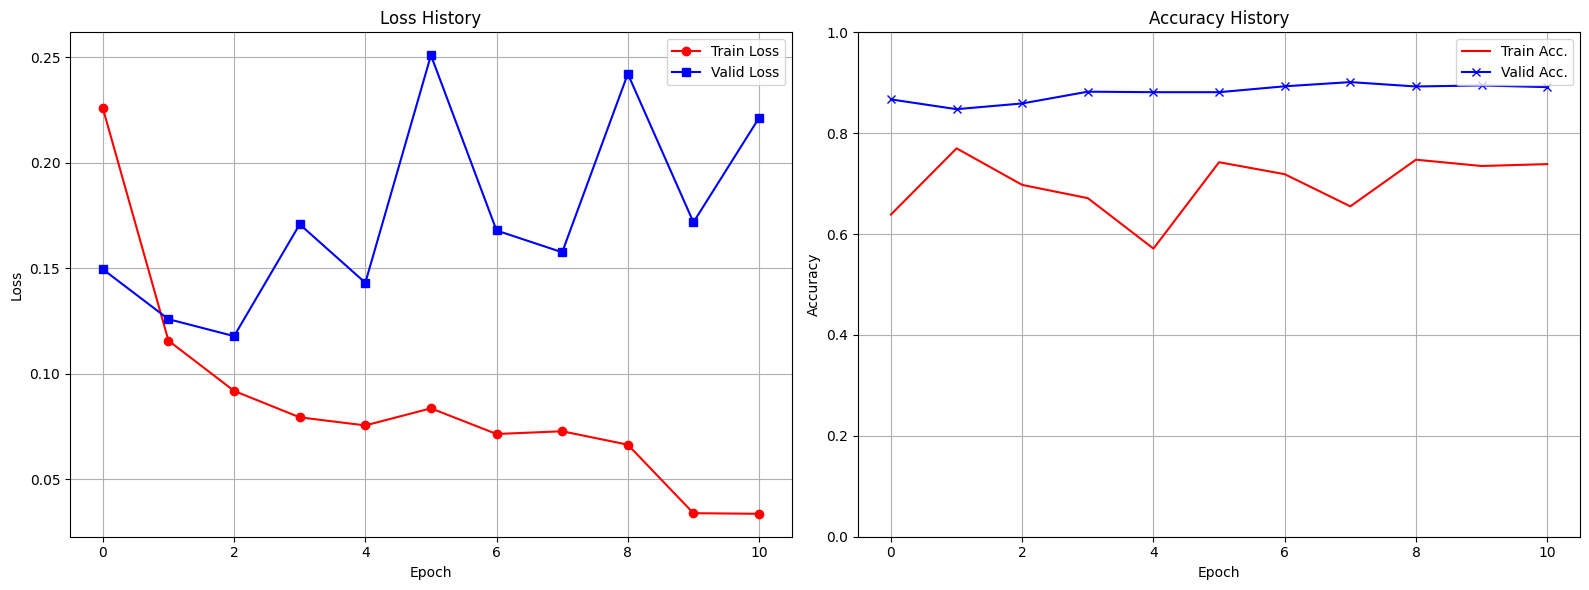

원본 훈련 정확도: [6.3875, 7.7, 6.975, 6.7125, 5.7125, 7.425, 7.1875, 6.55, 7.475, 7.35, 7.3875]
원본 검증 정확도: [8.67, 8.476666666666667, 8.59, 8.823333333333334, 8.813333333333333, 8.813333333333333, 8.93, 9.013333333333334, 8.926666666666666, 8.946666666666667, 8.913333333333334]
정규화된 훈련 정확도: [0.63875, 0.77, 0.6975, 0.67125, 0.57125, 0.7424999999999999, 0.71875, 0.655, 0.7474999999999999, 0.735, 0.73875]
정규화된 검증 정확도: [0.867, 0.8476666666666667, 0.859, 0.8823333333333334, 0.8813333333333333, 0.8813333333333333, 0.893, 0.9013333333333333, 0.8926666666666666, 0.8946666666666667, 0.8913333333333334]


In [29]:
# 4. 학습 실행
try:
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    print("모델 학습 완료!")

    # 그래프 그리기
    accuracy_callback.plot_metrics(save_path=os.path.join(checkpoint_dir, 'training_history.png'))

except Exception as e:
    print(f"학습 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

사용 장치: cuda

분류 보고서:
                precision    recall  f1-score   support

      Standing       0.98      0.91      0.94       139
 Start Walking       0.47      0.85      0.61        20
       Walking       0.96      0.86      0.90       125
Finish Walking       0.55      0.75      0.63        16

      accuracy                           0.88       300
     macro avg       0.74      0.84      0.77       300
  weighted avg       0.91      0.88      0.89       300



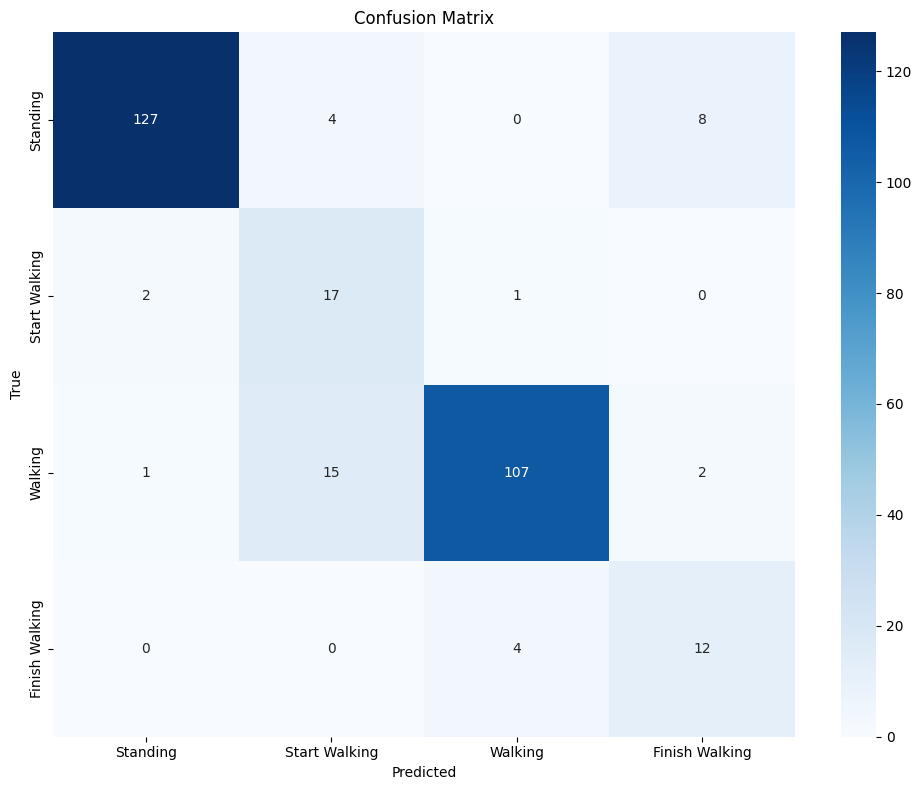

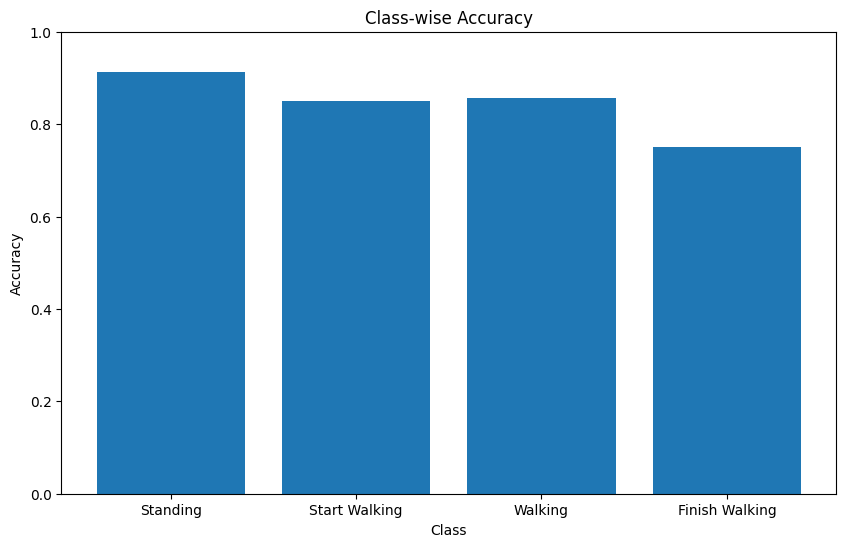

모델 평가 및 시각화 완료!


In [32]:
# 5. 평가 및 시각화 (학습 성공 시)
try:
    # 학습이 성공적으로 완료되면 최고 성능 모델 로드
    best_model_path = checkpoint_callback.best_model_path
    if os.path.exists(best_model_path):
        # 장치 지정
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"사용 장치: {device}")

        # 모델 로드 시 장치 명시
        best_tft = TemporalFusionTransformer.load_from_checkpoint(
            best_model_path,
            map_location=device
        )
        best_tft.to(device)  # 명시적으로 모델을 장치로 이동
        best_tft.eval()  # 평가 모드로 전환

        # 검증 데이터에 대한 예측 및 평가
        val_predictions = []
        val_targets = []

        for batch in val_dataloader:
            x, y = batch

            # 데이터를 모델과 동일한 장치로 이동
            if isinstance(x, dict):
                # 딕셔너리인 경우 각 텐서를 이동
                for k in x:
                    if isinstance(x[k], torch.Tensor):
                        x[k] = x[k].to(device)
            else:
                x = x.to(device)

            if isinstance(y, (list, tuple)) and len(y) > 0:
                y = [yi.to(device) for yi in y if isinstance(yi, torch.Tensor)]
            elif isinstance(y, torch.Tensor):
                y = y.to(device)

            with torch.no_grad():
                predictions = best_tft(x)

            # 예측값 처리
            if isinstance(predictions, tuple):
                predictions = predictions[0]

            pred_labels = predictions.argmax(dim=-1).cpu().numpy()

            # 타겟값 처리 - 일관된 차원 처리
            if isinstance(y, (list, tuple)) and len(y) > 0:
                y = y[0]

            # 타겟값 형태 디버깅
            # print(f"타겟 텐서 형태: {y.shape}")

            # 타겟값 형태 수정
            if y.dim() > 1:
                if y.dim() == 2:
                    # [batch_size, 1] 형태인 경우
                    if y.size(1) == 1:
                        y = y.squeeze(1)
                elif y.dim() == 3:
                    # [batch_size, 1, 1] 형태인 경우
                    if y.size(1) == 1 and y.size(2) == 1:
                        y = y.squeeze()
                    else:
                        # 다른 3차원 형태의 경우, 첫 번째 값만 사용
                        y = y[:, 0, 0]

            targets = y.cpu().long().numpy()

            val_predictions.extend(pred_labels)
            val_targets.extend(targets)

        # 분류 보고서
        print("\n분류 보고서:")
        report = classification_report(
            val_targets,
            val_predictions,
            target_names=['Standing', 'Start Walking', 'Walking', 'Finish Walking']
        )
        print(report)

        # 혼동 행렬 시각화
        try:
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(val_targets, val_predictions)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=['Standing', 'Start Walking', 'Walking', 'Finish Walking'],
                      yticklabels=['Standing', 'Start Walking', 'Walking', 'Finish Walking'])
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(checkpoint_dir, 'confusion_matrix.png'))
            plt.show()

            # 클래스별 정확도 계산 및 시각화
            class_accuracy = np.zeros(4)  # 0~3 클래스에 대한 정확도 배열 초기화
            for i in range(min(4, len(cm))):
                if cm.sum(axis=1)[i] > 0:  # 0으로 나누기 방지
                    class_accuracy[i] = cm[i, i] / cm.sum(axis=1)[i]

            plt.figure(figsize=(10, 6))
            plt.bar(['Standing', 'Start Walking', 'Walking', 'Finish Walking'], class_accuracy)
            plt.xlabel('Class')
            plt.ylabel('Accuracy')
            plt.title('Class-wise Accuracy')
            plt.ylim(0, 1)
            plt.savefig(os.path.join(checkpoint_dir, 'class_accuracy.png'))
            plt.show()
        except Exception as e:
            print(f"시각화 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"최고 성능 모델 파일을 찾을 수 없습니다: {best_model_path}")
except Exception as e:
    print(f"평가 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

print("모델 평가 및 시각화 완료!")